In [ ]:
pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 7.4 MB/s 
     |████████████████████████████████| 6.3 MB 18.7 MB/s 
     |████████████████████████████████| 16.7 MB 4.3 MB/s 


In [ ]:
pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 109.1 MB/s 


In [ ]:
pip install pycrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32704 sha256=9dcc4f3e9ede764ae7d17070cbbec21a0c31100f36d19a2c8d37e6479d838b3a
  Stored in directory: /root/.cache/pip/wheels/3e/ce/32/1ec0aba6b9770681a423e82f0274c57d09ad2c20c2864901f9
Successfully built pycrs


In [ ]:
import geopandas as gpd
import glob
import os
from bisect import bisect_left, bisect_right
from os import listdir
from os.path import isfile, join
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from rasterio.mask import mask
import rasterio
from fiona.crs import from_epsg
from shapely.geometry import box
from pyproj import Transformer
import pycrs
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib import cm

In [ ]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [ ]:
# import points
points_fire = gpd.read_file('/content/drive/MyDrive/ml_wildfire/shapefiles/points_fire_sample.shp')
points_nofire = gpd.read_file('/content/drive/MyDrive/ml_wildfire/shapefiles/points_nofire_sample.shp')

In [ ]:
# import moisture maps
path = '/content/drive/MyDrive/ml_wildfire/lfmc_folder'
filenames = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('.tif')]

# get dates of map
dates = [f.split("map_")[1].split(".tif")[0] for f in filenames]
dates = [datetime.strptime(date_string, "%Y-%m-%d").date() for date_string in dates]
dates = sorted(dates)

Fire Tiles

In [ ]:
out_path = "/content/drive/MyDrive/ml_wildfire/input_data/fire"

for i in range(len(points_fire)):
    
    # get fire date
    fire_date = points_fire['IgntDate'].iloc[i]
    fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
    # print(fire_date)
    
    # get closest map to fire date
    nearest_date = dates[:bisect_left(dates, fire_date)][-1]
    nearest_date = nearest_date.strftime('%Y-%m-%d')
    
    # get file corresponding to nearest date
    file = "lfmc_map_{}.tif".format(nearest_date)
    
    # Input raster
    fp = os.path.join(path, file)

    # Read the data
    data = rasterio.open(fp)
    
    # Crop image to have coordinate in center
    x_center = points_fire['geometry'].iloc[i].x
    y_center = points_fire['geometry'].iloc[i].y

    transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
    x_center, y_center = transformer.transform(x_center,y_center)

    xmin = x_center - 16 * data.transform[4] # pixel size
    xmax = x_center + 15 * data.transform[4]
    ymin = y_center - 16 * (-data.transform[0])
    ymax = y_center + 15 * (-data.transform[0])
    
    # create bounding box
    bbox = box(ymin, xmin, ymax, xmax)
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    geo = geo.to_crs(crs = data.crs.data)
    
    coords = getFeatures(geo)
    
    # Save cropped image
    out_tif = os.path.join(out_path, 'fire_{}.tif'.format(i))
    print(out_tif)
    
    # Clip the raster with Polygon
    out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

    # copy the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)
#     print(' Tile {} out of {}'.format(i, len(points_fire)))

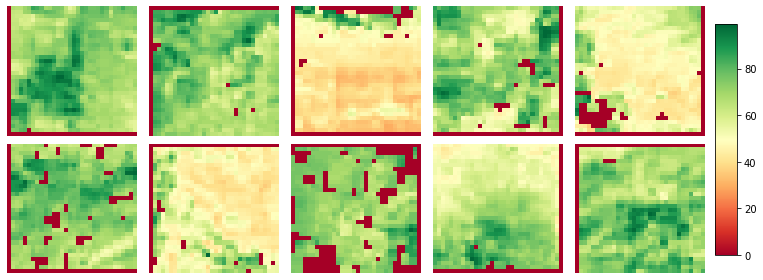

In [ ]:
# Visualize some images
out_path = "/content/drive/MyDrive/ml_wildfire/input_data/fire"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.tif')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
    idx = random.randint(0, len(images))
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[idx]))
    plt.imshow(src.read(1), cmap = cm.RdYlGn)
    plt.axis('off')

# plt.subplots_adjust(bottom=0.1, right=0.5, top=0.6)
fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

Non-Fire Tiles

In [ ]:
out_path = "/content/drive/MyDrive/ml_wildfire/input_data/nofire"

# for i in range(len(points_fire)):
for i in range(800):
    
    # get fire date
    idx = random.randint(0, len(points_fire)-1)
    fire_date = points_fire['IgntDate'].iloc[idx]
    fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
    
    # get range not within 1 year of fire (6 months before and 6 months after)
    prev_6 = fire_date + relativedelta(months = -6)
    next_6 = fire_date + relativedelta(months = +6)
    date_range = dates[:bisect_left(dates, prev_6)]
    date_range.extend(dates[bisect_right(dates, next_6):])
    
    # get random date in date_range
    rnd_ind = random.randint(0, len(date_range)-1)
    chosen_date = date_range[rnd_ind].strftime('%Y-%m-%d')
    
    # get file corresponding to nearest date
    file = "lfmc_map_{}.tif".format(chosen_date)
    
    # Input raster
    fp = os.path.join(path, file)

    # Read the data
    data = rasterio.open(fp)
    
    # Crop image to have coordinate in center
    x_center = points_fire['geometry'].iloc[idx].x
    y_center = points_fire['geometry'].iloc[idx].y

    transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
    x_center, y_center = transformer.transform(x_center,y_center)

    xmin = x_center - 16 * data.transform[4] # pixel size
    xmax = x_center + 15 * data.transform[4]
    ymin = y_center - 16 * (-data.transform[0])
    ymax = y_center + 15 * (-data.transform[0])
    
    # create bounding box
    bbox = box(ymin, xmin, ymax, xmax)
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    geo = geo.to_crs(crs = data.crs.data)
    
    coords = getFeatures(geo)
    
    # Save cropped image
    out_tif = os.path.join(out_path, 'nofire_{}.tif'.format(i))
    print(out_tif)
    
    # Clip the raster with Polygon
    out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

    # copy the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)

In [ ]:
# For non-fire points
out_path = "/content/drive/MyDrive/ml_wildfire/input_data/nofire"

# for i in range(len(points_fire)):
for i in range(801,1601):
    
    # get fire date
    idx = random.randint(0, len(points_nofire)-1)
    fire_date = points_fire['IgntDate'].iloc[idx]
    fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
    
    # get range not within 1 year of fire (6 months before and 6 months after)
    prev_6 = fire_date + relativedelta(months = -6)
    next_6 = fire_date + relativedelta(months = +6)
    date_range = dates[:bisect_left(dates, prev_6)]
    date_range.extend(dates[bisect_right(dates, next_6):])
    
    # get random date in date_range
    rnd_ind = random.randint(0, len(date_range)-1)
    chosen_date = date_range[rnd_ind].strftime('%Y-%m-%d')
    
    # get file corresponding to nearest date
    file = "lfmc_map_{}.tif".format(chosen_date)
    
    # Input raster
    fp = os.path.join(path, file)

    # Read the data
    data = rasterio.open(fp)
    
    # Crop image to have coordinate in center
    x_center = points_fire['geometry'].iloc[idx].x
    y_center = points_fire['geometry'].iloc[idx].y

    transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
    x_center, y_center = transformer.transform(x_center,y_center)

    xmin = x_center - 16 * data.transform[4] # pixel size
    xmax = x_center + 15 * data.transform[4]
    ymin = y_center - 16 * (-data.transform[0])
    ymax = y_center + 15 * (-data.transform[0])
    
    # create bounding box
    bbox = box(ymin, xmin, ymax, xmax)
    geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
    geo = geo.to_crs(crs = data.crs.data)
    
    coords = getFeatures(geo)
    
    # Save cropped image
    out_tif = os.path.join(out_path, 'nofire_{}.tif'.format(i))
    print(out_tif)
    
    # Clip the raster with Polygon
    out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

    # copy the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(out_img)

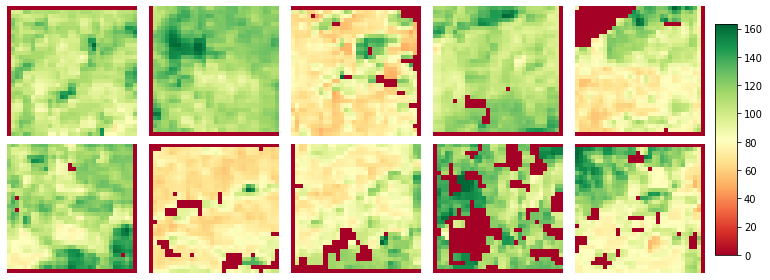

In [ ]:
# Visualize some images
out_path = "/content/drive/MyDrive/ml_wildfire/input_data/nofire"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.tif')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
    idx = random.randint(0, len(images))
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[idx]))
    plt.imshow(src.read(1), cmap = cm.RdYlGn)
    plt.axis('off')

fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#splitting into train & val for cnn model
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/ml_wildfire/input_data", output="/content/drive/MyDrive/ml_wildfire/processed_data", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 3528 files [01:35, 36.97 files/s]


Combining 3 months data

In [ ]:
out_path = "/content/drive/MyDrive/ml_wildfire/input_3data/3m_fire"

for i in range(len(points_fire)):
# for i in range(1):

    # get fire date
    fire_date = points_fire['IgntDate'].iloc[i]
    fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
#     print(fire_date)
    
    dates_list = []
    
    # get closest map to fire date
    nearest_date = dates[:bisect_left(dates, fire_date)][-1]
    nearest_date_str = nearest_date.strftime('%Y-%m-%d')
    dates_list.append(nearest_date_str)
    
    # get 1 month before
    dates_list.append((nearest_date + relativedelta(months = -1)).strftime('%Y-%m-%d'))
    dates_list.append((nearest_date + relativedelta(months = -2)).strftime('%Y-%m-%d'))
    
    image_array = np.zeros((3,32,32), dtype = np.uint16)
    print(' Tile {} out of {}'.format(i, len(points_fire)))
    
    for d in range(len(dates_list)):
        # get file corresponding to nearest date
        file = "lfmc_map_{}.tif".format(dates_list[d])

        # Input raster
        fp = os.path.join(path, file)
        
        if not os.path.isfile(fp):
            print('skip ', fp)
            continue

        # Read the data
        data = rasterio.open(fp)

        # Crop image to have coordinate in center
        x_center = points_fire['geometry'].iloc[i].x
        y_center = points_fire['geometry'].iloc[i].y

        transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
        x_center, y_center = transformer.transform(x_center,y_center)

        xmin = x_center - 16 * data.transform[4] # pixel size
        xmax = x_center + 15 * data.transform[4]
        ymin = y_center - 16 * (-data.transform[0])
        ymax = y_center + 15 * (-data.transform[0])

        # create bounding box
        bbox = box(ymin, xmin, ymax, xmax)
        geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
        geo = geo.to_crs(crs = data.crs.data)

        coords = getFeatures(geo)

        # Save cropped image
        out_png = os.path.join(out_path, 'fire_{}.tif'.format(i))
#         print(out_tif)

        # Clip the raster with Polygon
        out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
        image_array[d,:,:] = out_img

    # copy the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "dtype": 'uint16',
                     "count": 3, # 3 bands
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

    with rasterio.open(out_png, "w", **out_meta) as dest:
        dest.write(image_array)

In [ ]:
out_path = "/content/drive/MyDrive/ml_wildfire/input_3datapng/3m_firepng"

for i in range(len(points_fire)):
# for i in range(1):

    # get fire date
    fire_date = points_fire['IgntDate'].iloc[i]
    fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
#     print(fire_date)
    
    dates_list = []
    
    # get closest map to fire date
    nearest_date = dates[:bisect_left(dates, fire_date)][-1]
    nearest_date_str = nearest_date.strftime('%Y-%m-%d')
    dates_list.append(nearest_date_str)
    
    # get 1 month before
    dates_list.append((nearest_date + relativedelta(months = -1)).strftime('%Y-%m-%d'))
    dates_list.append((nearest_date + relativedelta(months = -2)).strftime('%Y-%m-%d'))
    
    image_array = np.zeros((3,32,32), dtype = np.uint16)
    print(' Tile {} out of {}'.format(i, len(points_fire)))
    
    for d in range(len(dates_list)):
        # get file corresponding to nearest date
        file = "lfmc_map_{}.tif".format(dates_list[d])

        # Input raster
        fp = os.path.join(path, file)
        
        if not os.path.isfile(fp):
            print('skip ', fp)
            continue

        # Read the data
        data = rasterio.open(fp)

        # Crop image to have coordinate in center
        x_center = points_fire['geometry'].iloc[i].x
        y_center = points_fire['geometry'].iloc[i].y

        transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
        x_center, y_center = transformer.transform(x_center,y_center)

        xmin = x_center - 16 * data.transform[4] # pixel size
        xmax = x_center + 15 * data.transform[4]
        ymin = y_center - 16 * (-data.transform[0])
        ymax = y_center + 15 * (-data.transform[0])

        # create bounding box
        bbox = box(ymin, xmin, ymax, xmax)
        geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
        geo = geo.to_crs(crs = data.crs.data)

        coords = getFeatures(geo)

        # Save cropped image
        out_png = os.path.join(out_path, 'fire_{}.png'.format(i))
#         print(out_tif)

        # Clip the raster with Polygon
        out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
        image_array[d,:,:] = out_img

    # copy the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "PNG",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "dtype": 'uint16',
                     "count": 3, # 3 bands
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})

    with rasterio.open(out_png, "w", **out_meta) as dest:
        dest.write(image_array)

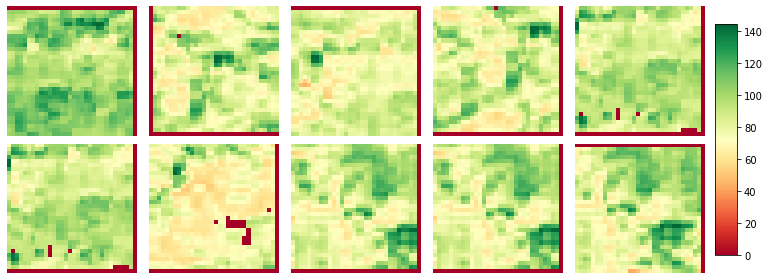

In [ ]:
# Visualize some images
out_path = "/content/drive/MyDrive/ml_wildfire/input_3data/3m_fire"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.tif')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
    idx = random.randint(0, len(images))
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[i]))
    plt.imshow(src.read(3), cmap = cm.RdYlGn)
    plt.axis('off')

# plt.subplots_adjust(bottom=0.1, right=0.5, top=0.6)
fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

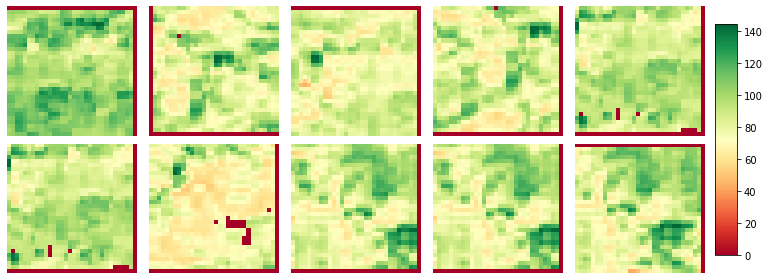

In [ ]:
# Visualize some images
out_path = "/content/drive/MyDrive/ml_wildfire/input_3datapng/3m_firepng"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.png')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
    idx = random.randint(0, len(images))
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[i]))
    plt.imshow(src.read(3), cmap = cm.RdYlGn)
    plt.axis('off')

# plt.subplots_adjust(bottom=0.1, right=0.5, top=0.6)
fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

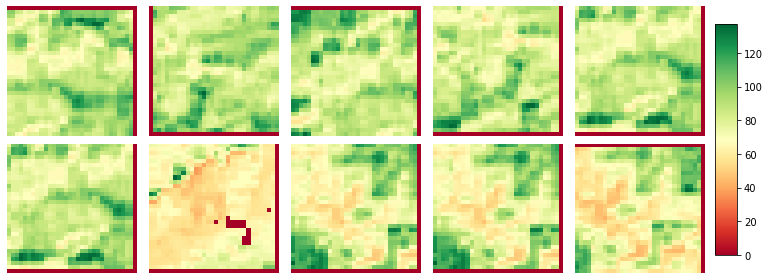

In [ ]:
# Visualize some images
out_path = "/content/drive/MyDrive/ml_wildfire/input_3data/3m_fire"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.tif')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
    idx = random.randint(0, len(images))
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[i]))
    plt.imshow(src.read(1), cmap = cm.RdYlGn)
    plt.axis('off')

# plt.subplots_adjust(bottom=0.1, right=0.5, top=0.6)
fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

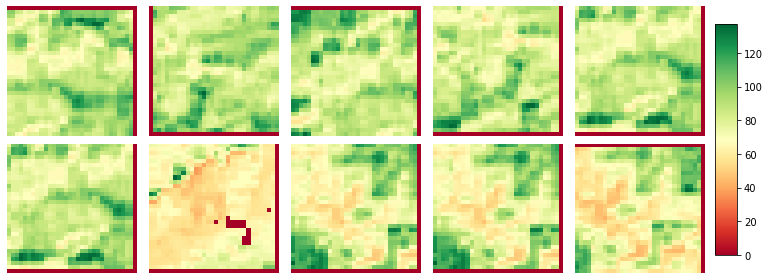

In [ ]:
# Visualize some images
out_path = "/content/drive/MyDrive/ml_wildfire/input_3datapng/3m_firepng"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.png')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
    idx = random.randint(0, len(images))
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[i]))
    plt.imshow(src.read(1), cmap = cm.RdYlGn)
    plt.axis('off')

# plt.subplots_adjust(bottom=0.1, right=0.5, top=0.6)
fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [ ]:
out_path = "/content/drive/MyDrive/ml_wildfire/input_3data/3m_nofire"

# for i in range(len(points_fire)):
for i in range(800):
    
    # get fire date
    idx = random.randint(0, len(points_fire)-1)
    fire_date = points_fire['IgntDate'].iloc[idx]
    fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
    
    # get range not within 1 year of fire (6 months before and 6 months after)
    prev_6 = fire_date + relativedelta(months = -6)
    next_6 = fire_date + relativedelta(months = +6)
    date_range = dates[:bisect_left(dates, prev_6)]
    date_range.extend(dates[bisect_right(dates, next_6):])
    
    # get random date in date_range
    rnd_ind = random.randint(0, len(date_range)-1)
    chosen_date = date_range[rnd_ind].strftime('%Y-%m-%d')
    
    dates_list = []
    dates_list.append(chosen_date)
    
    # get 1 month before
    dates_list.append((date_range[rnd_ind] + relativedelta(months = -1)).strftime('%Y-%m-%d'))
    dates_list.append((date_range[rnd_ind] + relativedelta(months = -2)).strftime('%Y-%m-%d'))
    
    image_array = np.zeros((3,32,32), dtype = np.uint16)
    print(' Tile {} out of {}'.format(i, 800))
    
    for d in range(len(dates_list)):
        # get file corresponding to nearest date
        file = "lfmc_map_{}.tif".format(dates_list[d])

        # Input raster
        fp = os.path.join(path, file)
        
        if not os.path.isfile(fp):
            print('skip ', fp)
            continue

        # Read the data
        data = rasterio.open(fp)

        # Crop image to have coordinate in center
        x_center = points_fire['geometry'].iloc[idx].x
        y_center = points_fire['geometry'].iloc[idx].y

        transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
        x_center, y_center = transformer.transform(x_center,y_center)

        xmin = x_center - 16 * data.transform[4] # pixel size
        xmax = x_center + 15 * data.transform[4]
        ymin = y_center - 16 * (-data.transform[0])
        ymax = y_center + 15 * (-data.transform[0])

        # create bounding box
        bbox = box(ymin, xmin, ymax, xmax)
        geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
        geo = geo.to_crs(crs = data.crs.data)

        coords = getFeatures(geo)

        # Save cropped image
        out_tif = os.path.join(out_path, 'nofire_{}.tif'.format(i))
#         print(out_tif)

        # Clip the raster with Polygon
        out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
        image_array[d, :, :] = out_img

    # copy the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "dtype": 'uint16',
                     "count": 3, 
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(image_array)

In [ ]:
out_path = "/content/drive/MyDrive/ml_wildfire/input_3datapng/3m_nofirepng"

# for i in range(len(points_fire)):
for i in range(800):
    
    # get fire date
    idx = random.randint(0, len(points_fire)-1)
    fire_date = points_fire['IgntDate'].iloc[idx]
    fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
    
    # get range not within 1 year of fire (6 months before and 6 months after)
    prev_6 = fire_date + relativedelta(months = -6)
    next_6 = fire_date + relativedelta(months = +6)
    date_range = dates[:bisect_left(dates, prev_6)]
    date_range.extend(dates[bisect_right(dates, next_6):])
    
    # get random date in date_range
    rnd_ind = random.randint(0, len(date_range)-1)
    chosen_date = date_range[rnd_ind].strftime('%Y-%m-%d')
    
    dates_list = []
    dates_list.append(chosen_date)
    
    # get 1 month before
    dates_list.append((date_range[rnd_ind] + relativedelta(months = -1)).strftime('%Y-%m-%d'))
    dates_list.append((date_range[rnd_ind] + relativedelta(months = -2)).strftime('%Y-%m-%d'))
    
    image_array = np.zeros((3,32,32), dtype = np.uint16)
    print(' Tile {} out of {}'.format(i, 800))
    
    for d in range(len(dates_list)):
        # get file corresponding to nearest date
        file = "lfmc_map_{}.tif".format(dates_list[d])

        # Input raster
        fp = os.path.join(path, file)
        
        if not os.path.isfile(fp):
            print('skip ', fp)
            continue

        # Read the data
        data = rasterio.open(fp)

        # Crop image to have coordinate in center
        x_center = points_fire['geometry'].iloc[idx].x
        y_center = points_fire['geometry'].iloc[idx].y

        transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
        x_center, y_center = transformer.transform(x_center,y_center)

        xmin = x_center - 16 * data.transform[4] # pixel size
        xmax = x_center + 15 * data.transform[4]
        ymin = y_center - 16 * (-data.transform[0])
        ymax = y_center + 15 * (-data.transform[0])

        # create bounding box
        bbox = box(ymin, xmin, ymax, xmax)
        geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
        geo = geo.to_crs(crs = data.crs.data)

        coords = getFeatures(geo)

        # Save cropped image
        out_tif = os.path.join(out_path, 'nofire_{}.png'.format(i))
#         print(out_tif)

        # Clip the raster with Polygon
        out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
        image_array[d, :, :] = out_img

    # copy the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "PNG",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "dtype": 'uint16',
                     "count": 3, 
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(image_array)

In [ ]:
out_path = "/content/drive/MyDrive/ml_wildfire/input_3data/3m_nofire"

# for i in range(len(points_fire)):
for i in range(801,1601):
    
    # get fire date
    idx = random.randint(0, len(points_nofire)-1)
    fire_date = points_fire['IgntDate'].iloc[idx]
    fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
    
    # get range not within 1 year of fire (6 months before and 6 months after)
    prev_6 = fire_date + relativedelta(months = -6)
    next_6 = fire_date + relativedelta(months = +6)
    date_range = dates[:bisect_left(dates, prev_6)]
    date_range.extend(dates[bisect_right(dates, next_6):])
    
    # get random date in date_range
    rnd_ind = random.randint(0, len(date_range)-1)
    chosen_date = date_range[rnd_ind].strftime('%Y-%m-%d')
    
    dates_list = []
    dates_list.append(chosen_date)
    
    # get 1 month before
    dates_list.append((date_range[rnd_ind] + relativedelta(months = -1)).strftime('%Y-%m-%d'))
    dates_list.append((date_range[rnd_ind] + relativedelta(months = -2)).strftime('%Y-%m-%d'))
    
    image_array = np.zeros((3,32,32), dtype = np.uint16)
    print(' Tile {} out of {}'.format(i, 1600))
    
    for d in range(len(dates_list)):
    
        # get file corresponding to nearest date
        file = "lfmc_map_{}.tif".format(dates_list[d])

        # Input raster
        fp = os.path.join(path, file)
        
        if not os.path.isfile(fp):
            print('skip ', fp)
            continue

        # Read the data
        data = rasterio.open(fp)

        # Crop image to have coordinate in center
        x_center = points_fire['geometry'].iloc[idx].x
        y_center = points_fire['geometry'].iloc[idx].y

        transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
        x_center, y_center = transformer.transform(x_center,y_center)

        xmin = x_center - 16 * data.transform[4] # pixel size
        xmax = x_center + 15 * data.transform[4]
        ymin = y_center - 16 * (-data.transform[0])
        ymax = y_center + 15 * (-data.transform[0])

        # create bounding box
        bbox = box(ymin, xmin, ymax, xmax)
        geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
        geo = geo.to_crs(crs = data.crs.data)

        coords = getFeatures(geo)

        # Save cropped image
        out_tif = os.path.join(out_path, 'nofire_{}.tif'.format(i))
#         print(out_tif)

        # Clip the raster with Polygon
        out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
        image_array[d, :, :] = out_img

    # copy the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "GTiff",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "dtype": 'uint16',
                     "count": 3, 
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(image_array)

In [ ]:
out_path = "/content/drive/MyDrive/ml_wildfire/input_3datapng/3m_nofirepng"

# for i in range(len(points_fire)):
for i in range(801,1601):
    
    # get fire date
    idx = random.randint(0, len(points_nofire)-1)
    fire_date = points_fire['IgntDate'].iloc[idx]
    fire_date = datetime.strptime(fire_date, "%Y-%m-%d").date()
    
    # get range not within 1 year of fire (6 months before and 6 months after)
    prev_6 = fire_date + relativedelta(months = -6)
    next_6 = fire_date + relativedelta(months = +6)
    date_range = dates[:bisect_left(dates, prev_6)]
    date_range.extend(dates[bisect_right(dates, next_6):])
    
    # get random date in date_range
    rnd_ind = random.randint(0, len(date_range)-1)
    chosen_date = date_range[rnd_ind].strftime('%Y-%m-%d')
    
    dates_list = []
    dates_list.append(chosen_date)
    
    # get 1 month before
    dates_list.append((date_range[rnd_ind] + relativedelta(months = -1)).strftime('%Y-%m-%d'))
    dates_list.append((date_range[rnd_ind] + relativedelta(months = -2)).strftime('%Y-%m-%d'))
    
    image_array = np.zeros((3,32,32), dtype = np.uint16)
    print(' Tile {} out of {}'.format(i, 1600))
    
    for d in range(len(dates_list)):
    
        # get file corresponding to nearest date
        file = "lfmc_map_{}.tif".format(dates_list[d])

        # Input raster
        fp = os.path.join(path, file)
        
        if not os.path.isfile(fp):
            print('skip ', fp)
            continue

        # Read the data
        data = rasterio.open(fp)

        # Crop image to have coordinate in center
        x_center = points_fire['geometry'].iloc[idx].x
        y_center = points_fire['geometry'].iloc[idx].y

        transformer = Transformer.from_crs("epsg:3857", "epsg:4326")
        x_center, y_center = transformer.transform(x_center,y_center)

        xmin = x_center - 16 * data.transform[4] # pixel size
        xmax = x_center + 15 * data.transform[4]
        ymin = y_center - 16 * (-data.transform[0])
        ymax = y_center + 15 * (-data.transform[0])

        # create bounding box
        bbox = box(ymin, xmin, ymax, xmax)
        geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
        geo = geo.to_crs(crs = data.crs.data)

        coords = getFeatures(geo)

        # Save cropped image
        out_tif = os.path.join(out_path, 'nofire_{}.png'.format(i))
#         print(out_tif)

        # Clip the raster with Polygon
        out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)
        image_array[d, :, :] = out_img

    # copy the metadata
    out_meta = data.meta.copy()
    epsg_code = int(data.crs.data['init'][5:])
    out_meta.update({"driver": "PNG",
                     "height": out_img.shape[1],
                     "width": out_img.shape[2],
                     "transform": out_transform,
                     "dtype": 'uint16',
                     "count": 3, 
                     "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})
    
    with rasterio.open(out_tif, "w", **out_meta) as dest:
        dest.write(image_array)

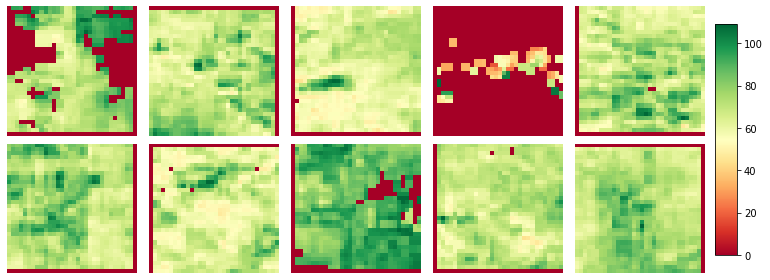

In [ ]:
# Visualize some images
out_path = "/content/drive/MyDrive/ml_wildfire/input_3data/3m_nofire"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.tif')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
#     idx = random.randint(0, len(images))
    idx = i + 50
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[idx]))
    plt.imshow(src.read(3), cmap = cm.RdYlGn)
    plt.axis('off')

fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

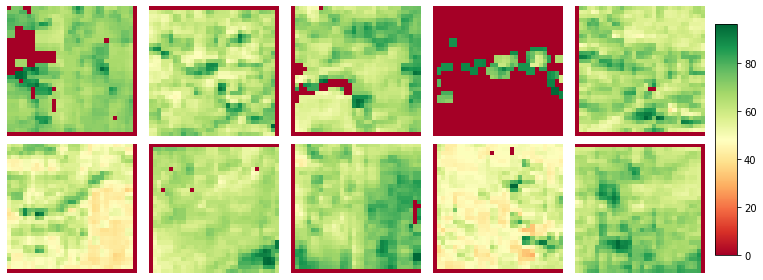

In [ ]:
# Visualize some images
out_path = "/content/drive/MyDrive/ml_wildfire/input_3data/3m_nofire"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.tif')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
#     idx = random.randint(0, len(images))
    idx = i + 50
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[idx]))
    plt.imshow(src.read(1), cmap = cm.RdYlGn)
    plt.axis('off')

fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

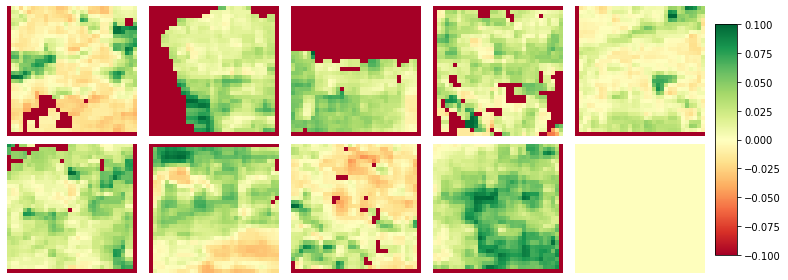

In [ ]:
# Visualize some images
out_path = "/content/drive/MyDrive/ml_wildfire/input_3datapng/3m_nofirepng"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.png')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
#     idx = random.randint(0, len(images))
    idx = i + 50
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[idx]))
    plt.imshow(src.read(3), cmap = cm.RdYlGn)
    plt.axis('off')

fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

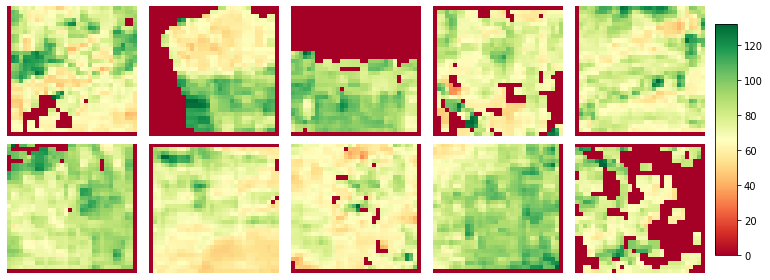

In [ ]:
# Visualize some images
out_path = "/content/drive/MyDrive/ml_wildfire/input_3datapng/3m_nofirepng"
images = [f for f in listdir(out_path) if isfile(join(out_path, f)) and f.endswith('.png')]

fig = plt.figure(figsize = (10,4))

for i in range(10):
#     idx = random.randint(0, len(images))
    idx = i + 50
    plt.subplot(2,5,i+1)
    src = rasterio.open(os.path.join(out_path, images[idx]))
    plt.imshow(src.read(1), cmap = cm.RdYlGn)
    plt.axis('off')

fig.tight_layout()
cax = plt.axes([1.0, 0.1, 0.03, 0.8])
plt.colorbar(cax=cax)
plt.show()

In [ ]:
#splitting into train and val for cnn model
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/ml_wildfire/input_3data", output="/content/drive/MyDrive/ml_wildfire/processed_3data", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 3528 files [01:25, 41.19 files/s]


In [ ]:
#splitting into train and val for cnn model
import splitfolders
splitfolders.ratio("/content/drive/MyDrive/ml_wildfire/input_3datapng", output="/content/drive/MyDrive/ml_wildfire/processed_3datapng", seed=1337, ratio=(.8, .2), group_prefix=None) # default values

Copying files: 7056 files [03:39, 32.17 files/s]
